In [71]:
import requests
from openai import AzureOpenAI
import os
import json
from pprint import pprint
from pprint import pprint
# dotenv
from dotenv import load_dotenv

if "OPENAI_API_KEY" in os.environ:
    os.environ.pop("OPENAI_API_KEY")
if "OPENAI_ENDPOINT" in os.environ:
    os.environ.pop("OPENAI_ENDPOINT")
if "AI_SEARCH_SERVICE" in os.environ:
    os.environ.pop("AI_SEARCH_SERVICE")
if "AI_SEARCH_KEY" in os.environ:
    os.environ.pop("AI_SEARCH_KEY")
if "AI_SEARCH_INDEX_NAME" in os.environ:
    os.environ.pop("AI_SEARCH_INDEX_NAME")
load_dotenv()
os.environ['AI_SEARCH_INDEX_NAME']='faqdemo-netrefer-index'


In [72]:
client = AzureOpenAI(
    api_key=os.environ['OPENAI_API_KEY'],
    azure_endpoint=os.environ['OPENAI_ENDPOINT'],
    api_version="2024-02-01"
)
print(os.environ['OPENAI_ENDPOINT'])

https://aash-openai-eastus2.openai.azure.com/


In [74]:
def get_embedding(text, model="text-embedding-ada-002"):
    response = client.embeddings.create(input=text,
    model=model)
    return response.data[0].embedding


In [73]:
# send a query to the AI Search service
service_name = os.environ['AI_SEARCH_SERVICE']
index_name = os.environ['AI_SEARCH_INDEX_NAME']
api_version = '2023-11-01'
api_key = os.environ['AI_SEARCH_KEY']
print(f"index_name: {index_name}")
print(f"service_name: {service_name}")
endpoint = f'https://{service_name}.search.windows.net/indexes/{index_name}/docs/search?api-version={api_version}'



index_name: faqdemo-netrefer-index
service_name: ai-search-aash-demo


In [75]:
# Create a new index
service_name = os.environ['AI_SEARCH_SERVICE']
name = os.environ['AI_SEARCH_INDEX_NAME']
url = f"https://{service_name}.search.windows.net/indexes/{name}?api-version=2023-11-01"
payload = json.dumps({
  "name": name,
  "fields": [
    {
      "name": "id", # the name of the field
      "type": "Edm.String", # the data type of the field
      "searchable": False, # whether the field is searchable. This determines whether the field is included in full-text searches.
      "filterable": True, # whether the field is filterable. This determines whether the field can be used in filter expressions.
      "retrievable": True, # whether the field is retrievable. This determines whether the field is included in search results.
      "sortable": False, # whether the field is sortable. This determines whether the field can be used in order-by expressions.
      "facetable": False, # whether the field is facetable. This determines whether the field can be used in facet expressions.
      "key": True, # whether the field is a key field. This determines whether the field uniquely identifies documents in the index.
      "indexAnalyzer": None, # the name of the analyzer used at indexing time for the field
      "searchAnalyzer": None, # the name of the analyzer used at search time for the field
      "analyzer": None, # the name of the analyzer used at both indexing and search time for the field
      "fields": [] # a list of sub-fields for complex fields like collections
    },
    {
      "name": "answer",
      "type": "Edm.String",
      "searchable": True,
      "filterable": True,
      "retrievable": True,
      "sortable": True,
      "facetable": False,
      "key": False,
      "indexAnalyzer": None,
      "searchAnalyzer": None,
      "analyzer": "en.microsoft",
      "fields": []
    },
    {
      "name": "AnswerVector",
      "type": "Collection(Edm.Single)",
      "searchable": True,
      "retrievable": True,
      "dimensions": 1536,
      "vectorSearchProfile": "my-vector-profile"
    },
    {
      "name": "filename",
      "type": "Edm.String",
      "searchable": True,
      "filterable": True,
      "retrievable": True,
      "sortable": True,
      "facetable": False,
      "key": False,
      "indexAnalyzer": None,
      "searchAnalyzer": None,
      "analyzer": None,
      "fields": []
    },
    {
      "name": "title",
      "type": "Edm.String",
      "searchable": True,
      "filterable": True,
      "retrievable": True,
      "sortable": True,
      "facetable": False,
      "key": False,
      "indexAnalyzer": None,
      "searchAnalyzer": None,
      "analyzer": None,
      "fields": []
    },
    {
      "name": "url",
      "type": "Edm.String",
      "searchable": True,
      "filterable": True,
      "retrievable": True,
      "sortable": True,
      "facetable": False,
      "key": False,
      "indexAnalyzer": None,
      "searchAnalyzer": None,
      "analyzer": None,
      "fields": []
    },
    {
      "name": "Tags",
      "type": "Collection(Edm.String)",
      "searchable": True,
      "filterable": True,
      "retrievable": True,
      "sortable": False,
      "facetable": True,
      "key": False,
      "indexAnalyzer": None,
      "searchAnalyzer": None,
      "analyzer": None,
      "fields": []
    }
],
  "corsOptions": {
    "allowedOrigins": [
      "*"
    ],
    "maxAgeInSeconds": 60
  },
  "vectorSearch": {
    "algorithms": [
      {
        "name": "my-hnsw-config",
        "kind": "hnsw",
        "hnswParameters": {
          "m": 4, # the number of bi-directional links created for each element during construction
          "efConstruction": 400, # the size of the dynamic list for the nearest neighbors (used during construction)
          "efSearch": 500, # the size of the dynamic list for the nearest neighbors (used during search)
          "metric": "cosine" # the distance metric used to compute the similarity between vectors
        }
      },
      {
        "name": "my-eknn-config",
        "kind": "exhaustiveKnn",
        "exhaustiveKnnParameters": {
          "metric": "cosine"
        }
      }
    ],
    "profiles": [
      {
        "name": "my-vector-profile",
        "algorithm": "my-hnsw-config"
      }
    ]
  },
  "semantic": {
    "configurations": [
      {
        "name": "my-semantic-config",
        "prioritizedFields": {
          "prioritizedContentFields": [
            {
              "fieldName": "answer"
            }
          ],
          "prioritizedKeywordsFields": [
            {
              "fieldName": "Tags"
            }
          ]
        }
      }
    ]
  }
})
headers = {
  'Content-Type': 'application/json',
  'api-key': os.environ['AI_SEARCH_KEY']
}

response = requests.request("PUT", url, headers=headers, data=payload)



In [78]:
# uploading the data
import importlib
import ai_search_upload_data
importlib.reload(ai_search_upload_data)

# Re-import the functions after reloading the module
from ai_search_upload_data import analyze_and_upload_docs, analyze_and_updload_images

# analyze the documents
docs = analyze_and_upload_docs()
print(f"docs: {docs}")
# analyze the images
images_urls = ["https://new2cloud.de/wp-content/uploads/2021/04/CreateAzureFreeAccount-1-1536x879.png"]
images = analyze_and_updload_images(images_urls)
print("Done")

https://aash-openai-eastus2.openai.azure.com/
https://aash-openai-eastus2.openai.azure.com/
Index name: faqdemo-netrefer-index
Service name: ai-search-aash-demo
Analyzing images...
Analyzing image https://new2cloud.de/wp-content/uploads/2021/04/CreateAzureFreeAccount-1-1536x879.png
{
    "image_description": "This image shows the services available under the Azure free trial. It features a grid layout with various service offerings each represented in individual cards. Some of the services and their specifications highlighted include: Linux Virtual Machines with 750 hours of B1S Standard tier, Windows Virtual Machines also with 750 hours of B1S Standard tier, Managed Disks with 64 GB x 2 of P6 solid state drives, Blob Storage with 5 GB of locally redundant storage, File Storage with 5 GB LRS file storage, SQL Database with 250 GB, VPN Gateway with 750 hours of VpnGw1 Gateway Type, Load Balancer with 750 hours, 15 GB data processing, and 5 rules, Azure Cosmos DB with 400 RU/s provisione

In [79]:
def build_payload_vector_search(user_query, k=7):
    return json.dumps({
        "count": True, # return the count of results
        "select": "id, answer, Tags", # return the specified fields
        "vectorQueries": [
            {
                "vector": get_embedding(user_query, model="text-embedding-ada-002"),
                "k": k, # k is the number of results to return
                "fields": "AnswerVector",
                "kind": "vector",
                "exhaustive": True
            }
        ]
    })

def answer_question_vector(user_query):
    payload = build_payload_vector_search(user_query, 3)
    headers = {
      'Content-Type': 'application/json',
        'api-key': api_key
    }
    response = requests.request("POST", endpoint, headers=headers, data=payload)
    return response.json()["value"]

In [80]:
def build_payload_hybrid_search(user_query, k=3, top=3):
    return json.dumps({
        "count": True,
        "search": user_query,
        "select": "id, answer, Tags, filename",
        "top": top,
        "vectorQueries": [
            {
                "vector": get_embedding(user_query, model="text-embedding-ada-002"),
                "k": k,
                "fields": "AnswerVector",
                "kind": "vector",
                "exhaustive": True
            }
        ]
    })

def answer_question_hybrid(user_query):
    payload = build_payload_hybrid_search(user_query)
    headers = {
      'Content-Type': 'application/json',
        'api-key': api_key
    }
    response = requests.request("POST", endpoint, headers=headers, data=payload)
    return response.json()["value"]

In [63]:
def build_payload_hybrid_search_semantic(user_query, k=3, top=3):
    return json.dumps({
        "count": True,
        "search": user_query,
        "queryType": "semantic",  # Enable semantic search
        "semanticConfiguration": "my-semantic-config",  # Apply the semantic configuration
        "select": "id, answer, Tags, filename",
        "top": top,
        "vectorQueries": [
            {
                "vector": get_embedding(user_query, model="text-embedding-ada-002"),
                "k": k,
                "fields": "AnswerVector",
                "kind": "vector",
                "exhaustive": True
            }
        ]
    })

def answer_question_hybrid_semantic(user_query):
    payload = build_payload_hybrid_search(user_query)
    headers = {
        'Content-Type': 'application/json',
        'api-key': api_key
    }
    response = requests.request("POST", endpoint, headers=headers, data=payload)
    return response.json()["value"]


In [81]:
def build_payload_keyword_search(user_query, top=3):
    return json.dumps({
        "count": True,
        "search": user_query,
        "select": "id, answer, Tags",
        "top": top
    })

def answer_question_keyword(user_query):
    payload = build_payload_keyword_search(user_query)
    headers = {
      'Content-Type': 'application/json',
        'api-key': api_key
    }
    response = requests.request("POST", endpoint, headers=headers, data=payload)
    return response.json()["value"]

In [82]:
# API end point
question = "Can I skip the 30 days and just start with pay-as-you-go pricing?"
prompt = "Q: " + question + "\nA:"
prompt = "I am searching for information about the question in 3 modes: keyword, vector, and hybrid search. Here are the results:\n\n"
res_keyword = answer_question_keyword(question)
prompt += "Keyword search:\n"
for r in res_keyword:
    prompt += f"the answer is: {r['answer']}\n"
    prompt += f"the search score is: {r['@search.score']}\n"
    print(r["answer"])
    print(r["Tags"])
    print(r["@search.score"])
    print(r["id"])
    print()
prompt+= "----end of keyword search----\n\n"

At the end of your first 30 days or after you spend your $200 credit (whichever comes first), we'll ask you if you want to move to pay-as-you-go pricing. If you move to pay as you go, you'll keep getting free services and you'll only pay for what you use beyond the free monthly amounts. If you don't move to pay as you go, you can't purchase Azure services beyond your $200 credit—and eventually your account and services will be disabled.
['FAQ', 'Azure']
8.884999
368cfc1f-d2d6-47c9-81ca-f75adf2541a7

You start getting monthly free amounts of more than 55 other services when you create your Azure free account. If you move to pay-as-you-go pricing after 30 days or after you use your credit, you’ll continue to receive monthly free amounts of these services. If you exceed your monthly free amounts for any of these services, you’ll be billed for them at pay-as-you-go rates.
['FAQ', 'Azure']
5.626695
d0a2b90d-2bae-4bd8-be57-84ee27fb6e1e

When you sign up for an Azure free account, you get $20

In [83]:
res_vector = answer_question_vector(question)
prompt += "Vector search:\n"
for r in res_vector:
    prompt += f"the answer is: {r['answer']}\n"
    prompt += f"the search score is: {r['@search.score']}\n"
    print(f"answer: {r['answer']}")
    print()
prompt+= "----end of vector search----\n\n"



answer: If you decide not to move to pay-as-you-go pricing after your first 30 days or once you've used up your $200 credit (whichever happens first), any services you've deployed will be decommissioned and you won't be able to access them. To regain access, move to pay as you go within the following 30 days.

answer: Yes. You can sign up directly for pay as you go. This will enable you to immediately use services beyond the free amounts at pay-as-you-go rates. You'll still get monthly free amounts of popular services for 12 months and more than 55 services that are always free, but you won't receive the $200 credit.

answer: Once you move to pay-as-you-go pricing, certain types of popular services are available in free monthly amounts for 12 months. If you're using any of these services after 12 months, they'll continue to run and you'll be billed at pay-as-you-go rates. You'll continue to receive monthly free amounts of more than 55 services that are always free.



In [84]:
res_hybrid = answer_question_hybrid(question)
prompt += "Hybrid search:\n"

for r in res_hybrid:
    prompt += f"the answer is: {r['answer']}\n"
    prompt += f"the search score is: {r['@search.score']}\n"
    print(f"answer: {r['answer']}")
    print(f"filename: {r['filename']}")
    print(f"Tags: {r['Tags']}")
    print(f"score: {r['@search.score']}")
    print(f"id: {r['id']}")
    print()
prompt+= "----end of hybrid search----\n\n"

answer: If you decide not to move to pay-as-you-go pricing after your first 30 days or once you've used up your $200 credit (whichever happens first), any services you've deployed will be decommissioned and you won't be able to access them. To regain access, move to pay as you go within the following 30 days.
filename: faqs.csv
Tags: ['FAQ', 'Azure']
score: 0.03181818127632141
id: 6737c8c9-021f-43fb-95a8-8022c6fb881e

answer: Yes. You can sign up directly for pay as you go. This will enable you to immediately use services beyond the free amounts at pay-as-you-go rates. You'll still get monthly free amounts of popular services for 12 months and more than 55 services that are always free, but you won't receive the $200 credit.
filename: faqs.csv
Tags: ['FAQ', 'Azure']
score: 0.03109932318329811
id: 26dc8d02-f889-43f8-b298-e9638c7baea5

answer: Once you move to pay-as-you-go pricing, certain types of popular services are available in free monthly amounts for 12 months. If you're using any

In [85]:
res_semantic = answer_question_hybrid_semantic(question)
prompt += "Hybrid search with semantic search:\n"
for r in res_semantic:
    prompt += f"the answer is: {r['answer']}\n"
    prompt += f"the search score is: {r['@search.score']}\n"
    print(f"answer: {r['answer']}")
    print()
prompt+= "----end of hybrid search with semantic search----\n\n"


answer: If you decide not to move to pay-as-you-go pricing after your first 30 days or once you've used up your $200 credit (whichever happens first), any services you've deployed will be decommissioned and you won't be able to access them. To regain access, move to pay as you go within the following 30 days.

answer: Yes. You can sign up directly for pay as you go. This will enable you to immediately use services beyond the free amounts at pay-as-you-go rates. You'll still get monthly free amounts of popular services for 12 months and more than 55 services that are always free, but you won't receive the $200 credit.

answer: Once you move to pay-as-you-go pricing, certain types of popular services are available in free monthly amounts for 12 months. If you're using any of these services after 12 months, they'll continue to run and you'll be billed at pay-as-you-go rates. You'll continue to receive monthly free amounts of more than 55 services that are always free.



In [87]:


prompt += """which of the methods do you think is the best that gave the most relevant results? 
rank them from 1 to 4 and explain the results\n\n"""

response = client.chat.completions.create(
    model="gpo-4o-global",
    messages=[
        {"role": "system", "content": prompt}
    ],  
    max_tokens=1000,
)
print()
print(response.choices[0].message.content)


Certainly! Here's a ranking of the search methods based on relevance and an explanation for each:

1. **Hybrid search with semantic search**
    - **Relevance: High**
    - **Explanation:** This method combines the benefits of both keyword and vector searches, while also incorporating semantic understanding. It provides highly contextual and relevant results, such as explaining what happens if you do not move to pay-as-you-go pricing after the initial 30 days, which directly answers the query. The top results are all highly pertinent and informative.

2. **Hybrid search**
    - **Relevance: High**
    - **Explanation:** This method also merges keyword and vector searches to deliver highly relevant results. The answers presented are quite similar to the results from the hybrid search with semantic search, indicating the critical actions required if you do not opt for the pay-as-you-go model after using up your credits or surpassing 30 days.

3. **Vector search**
    - **Relevance: Mode

In [88]:
question = "what are the services included in the Microsoft Azure free trial offer?"
answer_hybrid = answer_question_hybrid(question)

# pprint(f"hybrid={answer_hybrid}")
for answer in answer_hybrid:
    print(answer["Tags"])
    print(answer["@search.score"])
    print(answer["id"])
    print()

['FAQ', 'Azure', 'Image']
0.03333333507180214
81951b40-985e-478c-a240-6629d6804a53

['FAQ', 'Azure']
0.0317540317773819
30f0d35f-246f-4f88-9e69-14ad008a5968

['FAQ', 'Azure']
0.03067915514111519
d0a2b90d-2bae-4bd8-be57-84ee27fb6e1e



In [61]:
# putting images in the answer example


prompt = f"""the user question: {question}
The following data was retrieved from the Azure Search service:
"""
for answer in answer_hybrid:
    prompt += "----------------\n"
    prompt += f"""{answer["answer"]}\n"""
    if "Image" in answer["Tags"]:
        print(f"answer: {answer['Tags']}")
        prompt += f"""image_url: {answer["filename"]}"""
    prompt += "\n"
prompt += "----------------\n"
print(prompt)
response = client.chat.completions.create(
        model="gpt-4-turbo",
        response_format={ "type": "json_object" },
        messages=[
            {
                "role": "system",
                "content": """you are a bot that answers questions about Azure services
                                write an answer to the user. The answer can combine images and text. The answer should be informative and concise. answer shortly and only about what the user asked.
                                format the answer in a json structure with the following format:
                                {"answer": [
                                    {
                                        "type": "text",
                                        "content": <>
                                    },
                                    {
                                        "type": "image",
                                        "url": <>,
                                        "caption": <>
                                    }....
                                ]}
                                when integrating image into the answer, add text before the image that will explain what can be seen in the image. for exaple: In the following image, you can see....
                                the message will print the information in order of the list and will present the images from the urls."""
            }, {
                "role": "user",
                "content": prompt
            }
        ]
    )
# make sure that we take only the json by finding the first { and last } chars
res_json_str = response.choices[0].message.content[response.choices[0].message.content.find("{"):response.choices[0].message.content.rfind("}")+1]
res_json = json.loads(res_json_str)
pprint(res_json)


answer: ['FAQ', 'Azure', 'Image']
the user question: what are the servuces included in the Microsoft Azure free trial offer?
The following data was retrieved from the Azure Search service:
----------------
The image displays a list of services available under the Azure Free Trial. The services are organized into categories: Compute, Storage, Databases, Networking, Integration, and Containers. Each service includes specific details such as the amount of free usage, with examples like 750 hours of Linux and Windows Virtual Machines, 64 GB of Managed Disks (SSD), 5 GB of Blob and File Storage, 250 GB of SQL Database, and 400 RU/s provisioned throughput in Azure Cosmos DB. Additional services include VPN Gateway, Load Balancer, Service Bus, and Container Registry.
image_url: https://new2cloud.de/wp-content/uploads/2021/04/CreateAzureFreeAccount-1-1536x879.png
----------------
When you sign up for an Azure free account, you get $200 credit. In the first 30 days, any services you use beyond 

When you sign up for the Microsoft Azure free trial, you are entitled to a broad range of free services which are organized into different categories such as Compute, Storage, Databases, Networking, Integration, and Containers. Below is an illustration of the services included in the Azure Free Trial, detailing the free usage amounts for various services.

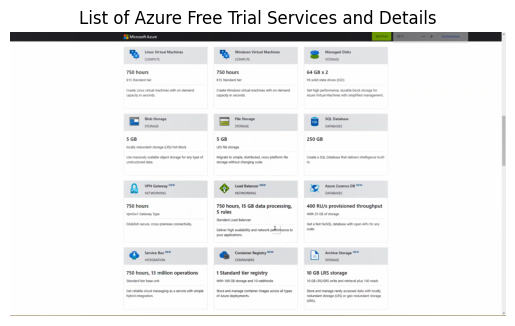

Additionally, as a new user, you receive a $200 credit to spend in the first 30 days on any Azure services beyond their free quota. After this period or upon exhausting the credit, you'll need to opt for pay-as-you-go pricing to continue using Azure services, whilst still enjoying the monthly free amounts of over 55 other services. Exceeding these free quotas will entail pay-as-you-go charges.

In [62]:
import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO
from IPython.display import display, Markdown


def display_response(response):
    for item in response['answer']:
        if item['type'] == 'text':
            display(Markdown(item['content']))
        elif item['type'] == 'image':
            response = requests.get(item['url'])
            img = Image.open(BytesIO(response.content))
            plt.imshow(img)
            plt.axis('off')
            plt.title(item['caption'])
            plt.show()

# Call the function to display the response
display_response(res_json)
